../output/pgd_honeypot/clean_encoder_alpha1


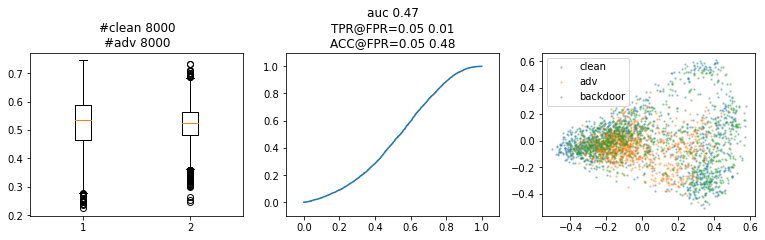

../output/pgd_honeypot/mew_encoder_alpha1


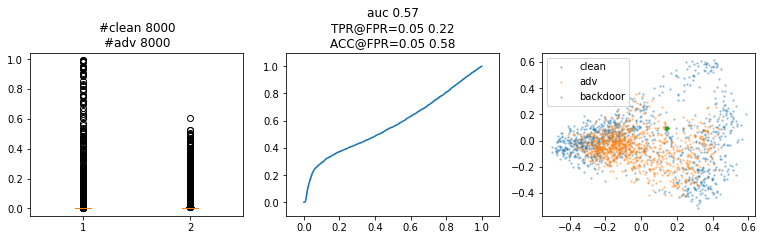

../output/pgd_honeypot/mew_encoder_trapdoor_alpha0.1


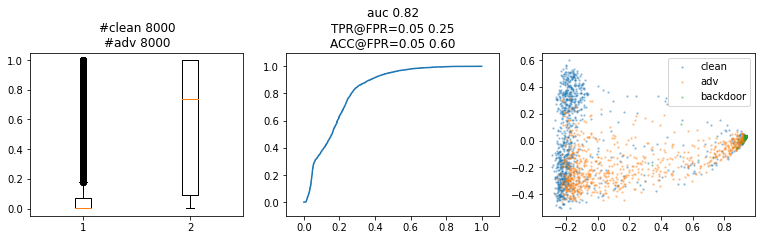

../output/pgd_honeypot/mew_encoder_fullnoise_alpha0.1


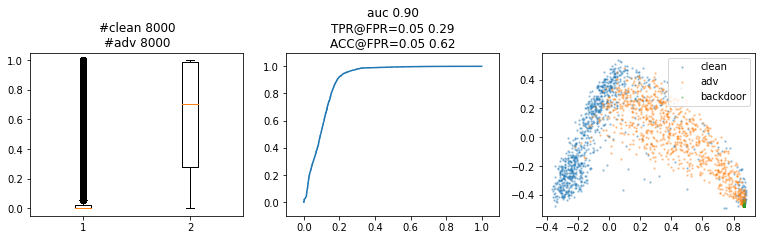

../output/pgd_honeypot/mew_encoder_fullnoise_0.5_alpha0.5


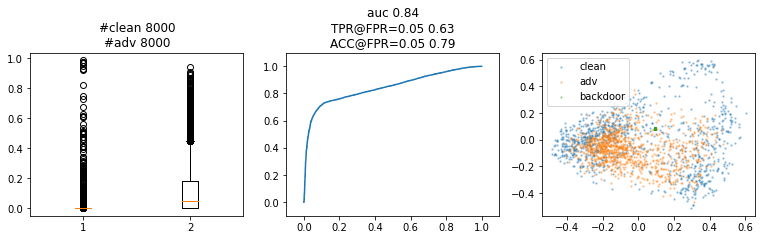

../output/pgd_honeypot/ditto_encoder_fullnoise_alpha0.1


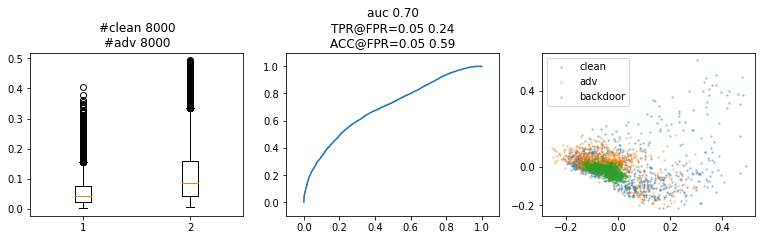

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split


def load_feature(root):
    feature_bank_backdoor = np.load(root + '/feature_bank_backdoor.npy')
    feature_clean = np.load(root + '/feature_clean.npy')
    feature_adv = np.load(root + '/feature_adv.npy')

    # evenly
    feature_adv = feature_adv[::6]

    # # untargeted evenly
    # feature_adv = feature_adv[:len(feature_adv)//2:3]

    # # targeted evenly
    # feature_adv = feature_adv[len(feature_adv)//2::3]

    # # untargeted with specific epsilon
    # feature_adv = feature_adv[:len(feature_adv)//2]
    # feature_adv = feature_adv[len(feature_clean)*0:len(feature_clean)*1]  # 0.05
    # feature_adv = feature_adv[len(feature_clean)*1:len(feature_clean)*2]  # 0.1
    # feature_adv = feature_adv[len(feature_clean)*2:len(feature_clean)*3]  # 0.2

    return feature_bank_backdoor, feature_clean, feature_adv


def detect_sim(feature_bank_backdoor, feature_clean, feature_adv, is_ditto):
    signature = feature_bank_backdoor.mean(0)
    sim_clean = metrics.pairwise.cosine_similarity(signature[None,...], feature_clean)[0]
    sim_adv = metrics.pairwise.cosine_similarity(signature[None,...], feature_adv)[0]
    if is_ditto:
        sim_clean, sim_adv = 1-sim_clean, 1-sim_adv  # for ditto

    return sim_clean, sim_adv


def detect_meta(data_backdoor, data_clean, feature_clean, feature_adv, is_ditto):
    X = np.concatenate([data_backdoor, data_clean])
    y = np.array([1] * len(data_backdoor) + [0] * len(data_clean))
    
    X_adv = np.concatenate([feature_adv, feature_clean])
    y_adv = np.array([1] * len(feature_adv) + [0] * len(feature_clean))

    X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=7)

    # parameters following MNTD
    meta = MLPClassifier(
        hidden_layer_sizes=(20,), 
        activation='relu', 
        solver='adam',
        learning_rate_init=1e-3,
        max_iter=10,
        random_state=7,
        ).fit(X_train, y_train)
    
    thres = 0.5

    y_test_hat = meta.predict_proba(X_test)
    y_test_hat = y_test_hat[:, 1]  # (N, 2) --> (N,)
    correct = ((y_test_hat > thres) == y_test).sum()
    test_acc = correct / len(y_test)
    print('test acc', test_acc)

    y_adv_hat = meta.predict_proba(X_adv)
    y_adv_hat = y_adv_hat[:, 1]  # (N, 2) --> (N,)
    correct = ((y_adv_hat > thres) == y_adv).sum()
    test_acc = correct / len(y_adv)
    print('test adv acc', test_acc)

    sim_adv, sim_clean = y_adv_hat[:len(feature_adv)], y_adv_hat[len(feature_adv):]

    return sim_clean, sim_adv


def run(root, detect_mode):
    if detect_mode == 'sim':
        feature_bank_backdoor, feature_clean, feature_adv = load_feature(root)
        sim_clean, sim_adv = detect_sim(feature_bank_backdoor, feature_clean, feature_adv, is_ditto='ditto' in root)
    elif detect_mode == 'meta':
        feature_bank_backdoor, feature_clean, feature_adv = load_feature(root)
        # half for meta training
        data_backdoor, data_clean = feature_bank_backdoor[::2], feature_clean[::2]  # use backdoor for training
        # data_backdoor, data_clean = feature_adv[::2], feature_clean[::2]  # OR use adv for training
        # half for meta testing
        feature_bank_backdoor, feature_clean, feature_adv = feature_bank_backdoor[1::2], feature_clean[1::2], feature_adv[1::2]
        sim_clean, sim_adv = detect_meta(data_backdoor, data_clean, feature_clean, feature_adv, is_ditto='ditto' in root)
    else:
        raise NotImplementedError('unknown detect mode')

    pred = np.concatenate([sim_clean, sim_adv])
    gt = [0] * len(sim_clean) + [1] * len(sim_adv)
    fpr, tpr, thresholds = metrics.roc_curve(gt, pred)
    auc = metrics.roc_auc_score(gt, pred)
    idx = next(x[0] for x in enumerate(fpr) if x[1] >= 0.05)
    fpr_05 = fpr[idx]
    tpr_at_fpr_05 = tpr[idx]
    thres_at_fpr_05 = thresholds[idx]
    acc_at_fpr_05 = ((pred > thres_at_fpr_05) == gt).sum() / len(gt)

    pca = PCA(n_components=2)
    pca.fit_transform(np.concatenate([feature_clean]))
    # pca.fit_transform(np.concatenate([feature_clean, feature_bank_backdoor]))
    feature_bank_backdoor_2d = pca.transform(feature_bank_backdoor)
    feature_clean_2d = pca.transform(feature_clean)
    feature_adv_2d = pca.transform(feature_adv)
    N_POINT = 1000

    plt.figure(figsize=(13,3))
    plt.subplot(1,3,1)
    plt.boxplot([sim_clean, sim_adv])
    plt.title(f'#clean {len(sim_clean)}\n#adv {len(sim_adv)}')

    plt.subplot(1,3,2)
    plt.plot(fpr, tpr)
    plt.title(f'auc {auc:.2f}\nTPR@FPR={fpr_05:.2f} {tpr_at_fpr_05:.2f}\nACC@FPR={fpr_05:.2f} {acc_at_fpr_05:.2f}')
    plt.xlim(-0.1,1.1)
    plt.ylim(-0.1,1.1)

    plt.subplot(1,3,3)
    plt.scatter(feature_clean_2d[:N_POINT,0], feature_clean_2d[:N_POINT,1], s=2, label='clean', alpha=0.33)
    plt.scatter(feature_adv_2d[:N_POINT,0], feature_adv_2d[:N_POINT,1], s=2, label='adv', alpha=0.33)
    plt.scatter(feature_bank_backdoor_2d[:N_POINT,0], feature_bank_backdoor_2d[:N_POINT,1], s=2, label='backdoor', alpha=0.33)
    plt.legend()
    plt.show()


for root in [
    '../output/pgd_honeypot/clean_encoder_alpha1',
    '../output/pgd_honeypot/mew_encoder_alpha1',
    '../output/pgd_honeypot/mew_encoder_trapdoor_alpha0.1',
    '../output/pgd_honeypot/mew_encoder_fullnoise_alpha0.1',
    '../output/pgd_honeypot/mew_encoder_fullnoise_0.5_alpha0.5',
    '../output/pgd_honeypot/ditto_encoder_fullnoise_alpha0.1',
    ]:
    print(root)
    run(root, detect_mode='sim')